<strong>Aluno</strong>: Victor São Paulo Ruela



In [53]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# Implementação do perceptron simples para um problema de classificação binário
class LinearPerceptron:
    def __init__(self, eta=0.01, max_epochs=100):
        self.eta = eta
        self.max_epochs = max_epochs

    def predict(self, x, w):
        N, _ = x.shape
        x_aug = np.hstack((-np.ones((N, 1)), x))
        u = x_aug @ w
        return np.sign(u)

    def train(self, x_train, y_train):
        # initialize the weight matrix
        N, n = x_train.shape
        x_aug = np.hstack((-np.ones((N, 1)), x_train))

        wt = np.random.rand(n+1) - 0.5
        n_epochs = 0

        while(n_epochs < self.max_epochs):
            # generate random indexes order
            xseq = np.arange(N)
            np.random.shuffle(xseq)

            for i_rand in xseq:
                yhati = 1.0 * ((x_aug[i_rand, :] @ wt) >= 0)
                ei = y_train[i_rand] - yhati
                # calculate step size
                dw = self.eta * ei * x_aug[i_rand, :]
                # update weight vector
                wt = wt + dw
            # increment number of epochs
            n_epochs = n_epochs + 1

        return wt

# Implementação do perceptron simples para um problema de classificação binário
class ELM:
    def __init__(self, p=5):
        self.p = p

    def predict(self, x, w, H, Z):
        N, _ = x.shape
        x_aug = np.hstack((-np.ones((N, 1)), x))
        H = np.tanh(x_aug @ Z)
        u = np.sign(H @ w)
        return u

    def train(self, x_train, y_train):
        N, n = x_train.shape
        # augment X
        x_aug = np.hstack((-np.ones((N, 1)), x_train))
        # create initial Z matrix
        Z = np.random.uniform(-0.5, 0.5, (n+1, self.p))
        # apply activation function: tanh
        H = np.tanh(x_aug @ Z)
        # calculate the weights
        w = np.linalg.pinv(H) @ y_train
        return w, H, Z

In [55]:
# load the breast cancer data
X_bc, y_bc = load_breast_cancer(return_X_y = True)
# convert the classes to -1 or 1
y_bc = pd.Series(y_bc).map({0:-1,1:1}).to_numpy()
# scale the data
scaler_bc = MinMaxScaler()
X_bc = scaler_bc.fit_transform(X_bc)

In [56]:
# load the statlog(heart) dataset
heart_df = pd.read_csv('heart.dat', sep=' ', header=None)
X_hd, y_hd = heart_df.iloc[:,:-1].to_numpy(), heart_df.iloc[:,-1].map({2:1, 1:-1}).to_numpy()
# scale the data
scaler_hd = MinMaxScaler()
X_hd = scaler_hd.fit_transform(X_hd)

In [83]:
# split the data
def train_test_split(X, y, ratio=0.7):
    N = len(y)
    x_rand = np.arange(N)
    np.random.shuffle(x_rand)
    i_split = int(np.floor(ratio * N))

    x_train, x_test = x_rand[:i_split], x_rand[i_split:]
    return X[x_train,:], y[x_train], X[x_test,:], y[x_test]

def elm_experiment_multiple_neurons(X_train, y_train, X_test, y_test, neurons):
    accuracy_results = []
    accuracy_results_train = []
    for p in neurons:
        model = ELM(p=p)
        # train the model on training set
        w, H, Z = model.train(X_train, y_train)
        # make predictions for the teste set
        yhat = model.predict(X_test, w, H, Z)
        yhat_train = model.predict(X_train, w, H, Z)
        # accuracy
        accuracy_test = 100 * np.sum(y_test == yhat)/len(yhat)
        accuracy_train = 100 * np.sum(y_train == yhat_train)/len(yhat_train)
        
        accuracy_results.append(accuracy_test)
        accuracy_results_train.append(accuracy_train)

    return accuracy_results, accuracy_results_train


def elm_experiment_single_neuron(X_train, y_train, X_test, y_test, p, N):
    model = ELM(p=p)
    accuracy_results = []
    accuracy_results_train = []
    for i in range(N):
        # train the model on training set
        w, H, Z = model.train(X_train, y_train)
        # make predictions for the teste set
        yhat = model.predict(X_test, w, H, Z)
        yhat_train = model.predict(X_train, w, H, Z)
        # accuracy
        accuracy_test = 100 * np.sum(y_test == yhat)/len(yhat)
        accuracy_train = 100 * np.sum(y_train == yhat_train)/len(yhat_train)
        
        accuracy_results.append(accuracy_test)
        accuracy_results_train.append(accuracy_train)

    return accuracy_results, accuracy_results_train

def elm_experiment_dataset_split(X, y, N=30, neurons=[5,10,30,50,100,300], plot=True):
    experiment_values_test = []
    experiment_values_train = []
    for i in range(N):
        # split the data
        X_train, y_train, X_test, y_test = train_test_split(X, y)
        # run for every neuron
        test_values, train_values = elm_experiment_multiple_neurons(X_train, y_train, X_test, y_test, neurons)

        experiment_values_test.append(test_values)
        experiment_values_train.append(train_values)

    def convert_results(res, set): 
        df = pd.DataFrame(res, columns=neurons).melt(value_vars=neurons,value_name='Acurácia', var_name='Neurônios')
        df['Conjunto'] = set
        return df

    train_values_df = convert_results(experiment_values_train, 'Treino')
    test_values_df = convert_results(experiment_values_test, 'Teste')
    
    experiment_values_df = pd.concat([train_values_df, test_values_df], ignore_index=True)
    if (plot==True):
        # Plot the accuracy boxplots
        plt.figure(figsize=(10,6))
        sns.boxplot(data=experiment_values_df, x='Conjunto',y='Acurácia', hue='Neurônios', showfliers=False)

        # Print the results table
        display(test_values_df.groupby(['Neurônios','Conjunto'])['Acurácia'].agg([np.mean, np.std]))

    return experiment_values_df


def elm_experiment_training(X, y, N=30, neurons=[5,10,30,50,100,300], plot=True):
    experiment_values_test = {}
    experiment_values_train = {}
    
    # split the data once
    X_train, y_train, X_test, y_test = train_test_split(X, y)

    for p in neurons:
        test_values, train_values = elm_experiment_single_neuron(X_train, y_train, X_test, y_test, p, N)
        experiment_values_test[p] = test_values
        experiment_values_train[p] = train_values

    def convert_results(res, set): 
        df = pd.DataFrame().from_dict(res).melt(value_vars=neurons,value_name='Acurácia', var_name='Neurônios')
        df['Conjunto'] = set
        return df

    train_values_df = convert_results(experiment_values_train, 'Treino')
    test_values_df = convert_results(experiment_values_test, 'Teste')
    
    experiment_values_df = pd.concat([train_values_df, test_values_df], ignore_index=True)
    if (plot==True):
        # Plot the accuracy boxplots
        plt.figure(figsize=(10,6))
        sns.boxplot(data=experiment_values_df, x='Conjunto',y='Acurácia', hue='Neurônios', showfliers=False)

        # Print the results table
        display(test_values_df.groupby(['Neurônios','Conjunto'])['Acurácia'].agg([np.mean, np.std]))

    return experiment_values_df

,,mean,std
Neurônios,Conjunto,,
5,Teste,89.317739,4.690781
10,Teste,93.567251,2.071837
30,Teste,95.984405,1.166899
50,Teste,95.886940,1.252207
100,Teste,95.750487,1.237524
300,Teste,83.430799,2.935381


,,mean,std
Neurônios,Conjunto,,
5,Teste,85.711501,6.988384
10,Teste,93.469786,1.647503
30,Teste,96.276803,0.914813
50,Teste,96.257310,0.792065
100,Teste,95.984405,1.525990
300,Teste,83.450292,3.358165


,Neurônios,Acurácia,Conjunto
0,5,73.869347,Treino
1,5,91.206030,Treino
2,5,69.095477,Treino
3,5,89.195980,Treino
4,5,90.201005,Treino
...,...,...,...
355,300,89.473684,Teste
356,300,87.719298,Teste
357,300,89.473684,Teste
358,300,77.777778,Teste


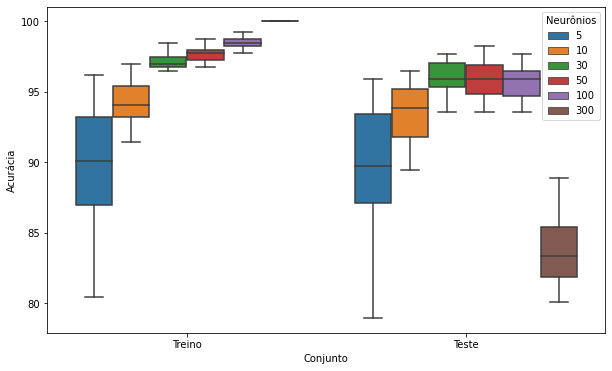

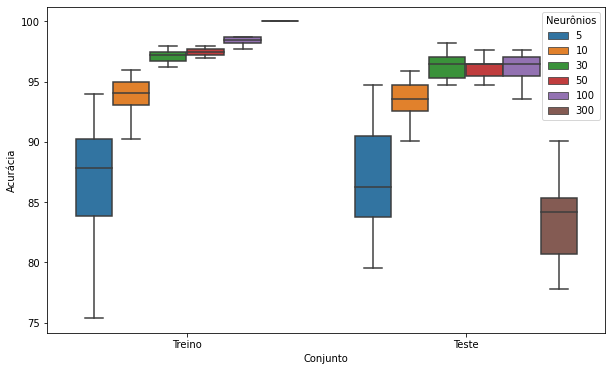

In [84]:
elm_experiment_dataset_split(X_bc, y_bc,neurons=[5,10,30,50,100,300])
elm_experiment_training(X_bc, y_bc,neurons=[5,10,30,50,100,300])

## Parte 2: Base Statlog (Heart)

In [ ]:
def perceptron_elm_experiment(X, y, N=5, print_results=True):
   
    model = LinearPerceptron(max_epochs=100)
    accuracy_results = []
    for i in range(N):
        # train the model on training set
        w = model.train(X_train, y_train)
        # make predictions for the teste set
        yhat = model.predict(X_test, w)
        # accuracy
        accuracy = 100 * np.sum(y_test == yhat)/len(yhat)
        accuracy_results.append(accuracy)
        
    if(print_results == True):
        plt.plot(accuracy_results, 'ko-')
        plt.xlabel('Iteração')
        plt.ylabel('Acurácia (%)')
        print(f'Média: {np.mean(accuracy_results)}')
        print(f'Desvio padrão: {np.std(accuracy_results)}')

,,mean,std
Neurônios,Conjunto,,
5,Teste,74.609053,6.267334
10,Teste,82.551440,3.254000
30,Teste,86.049383,1.976107
50,Teste,80.411523,2.745943
100,Teste,72.880658,3.484100
300,Teste,63.045267,4.324736


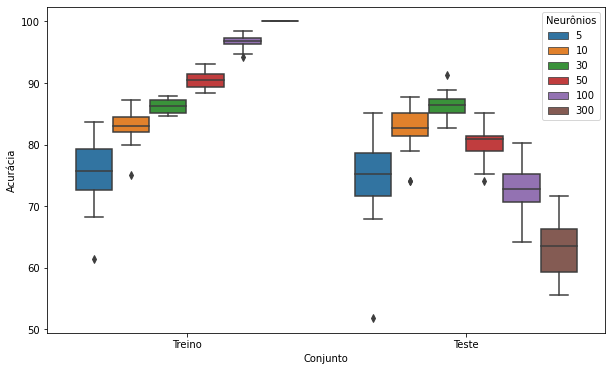

In [32]:
elm_experiment(X_hd, y_hd,neurons=[5,10,30,50,100,300])